# Reducing data-cubes using geometry objects

In [1]:
# If first time running, uncomment the line below to install any additional dependencies
# !bash requirements-for-notebooks.sh

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from earthkit import transforms as ekt
from earthkit import data as ekd

from earthkit.data.testing import earthkit_remote_test_data_file

## Load some test data

All `earthkit-transforms` methods can be called with `earthkit-data` objects (Readers and Wrappers) or with the 
pre-loaded `xarray` or `geopandas` objects.

In this example we will use hourly ERA5 2m temperature data on a 0.5x0.5 spatial grid for the year 2015 as
our physical data; and we will use the NUTS geometries which are stored in a geojson file.

First we lazily load the ERA5 data  and NUTS geometries from our test-data repository.

Note the data is only downloaded when
we use it, e.g. at the `.to_xarray` line, additionally, the download is cached so the next time you run this
cell you will not need to re-download the file (unless it has been a very long time since you have run the
code, please see tutorials in `earthkit-data` for more details in cache management).

In [3]:
# Get some demonstration ERA5 data, this could be any url or path to an ERA5 grib or netCDF file.
# remote_era5_file = earthkit_remote_test_data_file("test-data", "era5_temperature_europe_2015.grib") # Large file
remote_era5_file = earthkit_remote_test_data_file("test-data", "era5_temperature_europe_20150101.grib")
era5_data = ekd.from_source("url", remote_era5_file)
era5_xr = era5_data.to_xarray(time_dim_mode="valid_time").rename({"2t": "t2m"})
era5_xr

<xarray.Dataset> Size: 11MB
Dimensions:     (valid_time: 24, latitude: 201, longitude: 281)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 192B 2015-01-01 ... 2015-01-01T23...
  * latitude    (latitude) float64 2kB 80.0 79.75 79.5 79.25 ... 30.5 30.25 30.0
  * longitude   (longitude) float64 2kB -10.0 -9.75 -9.5 ... 59.5 59.75 60.0
Data variables:
    t2m         (valid_time, latitude, longitude) float64 11MB ...
Attributes: (12/13)
    param:        2t
    paramId:      167
    class:        ea
    stream:       oper
    levtype:      sfc
    type:         an
    ...           ...
    date:         20150101
    time:         0
    domain:       g
    number:       0
    Conventions:  CF-1.8
    institution:  ECMWF

In [4]:
# Use some demonstration polygons stored, this could be any url or path to geojson file
remote_nuts_url = earthkit_remote_test_data_file("test-data", "NUTS_RG_60M_2021_4326_LEVL_0.geojson")
nuts_data = ekd.from_source("url", remote_nuts_url)

nuts_data.to_pandas()[:5]

id NUTS_ID  LEVL_CODE CNTR_CODE NAME_LATN      NUTS_NAME  MOUNT_TYPE  \
0  DK      DK          0        DK   Danmark        Danmark           0   
1  RS      RS          0        RS    Serbia  Srbija/Сpбија           0   
2  EE      EE          0        EE     Eesti          Eesti           0   
3  EL      EL          0        EL    Elláda         Ελλάδα           0   
4  ES      ES          0        ES    España         España           0   

   URBN_TYPE  COAST_TYPE FID  \
0          0           0  DK   
1          0           0  RS   
2          0           0  EE   
3          0           0  EL   
4          0           0  ES   

                                            geometry  
0  MULTIPOLYGON (((15.1629 55.0937, 15.094 54.996...  
1  POLYGON ((21.4792 45.193, 21.3585 44.8216, 22....  
2  MULTIPOLYGON (((27.357 58.7871, 27.6449 57.981...  
3  MULTIPOLYGON (((28.0777 36.1182, 27.8606 35.92...  
4  MULTIPOLYGON (((4.391 39.8617, 4.1907 39.7981,...

## Reduce data
### Default behaviour

The default behaviour is to reduce the data along the spatial dimensions, only, and return the reduced data
in the Xarray format it was provided, i.e. `xr.DataArray` or `xr.Dataset`.

The returned object has a new dimension `FID` (feature id) which has a coordinate variable with the values
of the `FID` column in the input `geodataframe`.

The new variable name is made up of the original variable name and the method used to reduce, e.g. `t2m_mean`

In [5]:
reduced_data = ekt.spatial.reduce(era5_xr, nuts_data)
reduced_data

<xarray.Dataset> Size: 8kB
Dimensions:     (valid_time: 24, index: 37)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 192B 2015-01-01 ... 2015-01-01T23...
  * index       (index) int64 296B 0 1 2 3 4 5 6 7 8 ... 29 30 31 32 33 34 35 36
Data variables:
    t2m         (index, valid_time) float64 7kB 278.7 278.9 ... 272.7 272.6
Attributes: (12/13)
    param:        2t
    paramId:      167
    class:        ea
    stream:       oper
    levtype:      sfc
    type:         an
    ...           ...
    date:         20150101
    time:         0
    domain:       g
    number:       0
    Conventions:  CF-1.8
    institution:  ECMWF

### Reduce along additional dimension

For example, any time dimension, this is advisable as it ensures correct handling missing values and weights.

The extra_reduce_dims argument takes a single string or a list of strings corresponding to dimensions to
include in the reduction.

It is also possible to select a column in the geodataframe to use to populate the dimension and coordinate 
variable created by the reduction using the `mask_dim` kwarg, here we choose the `"FID"` column.

In [6]:
reduced_data = ekt.spatial.reduce(
    era5_xr, nuts_data,
    mask_dim="FID", extra_reduce_dims='valid_time', all_touched=True
)
reduced_data

<xarray.Dataset> Size: 592B
Dimensions:  (FID: 37)
Coordinates:
  * FID      (FID) object 296B 'DK' 'RS' 'EE' 'EL' 'ES' ... 'CY' 'CZ' 'DE' 'NO'
Data variables:
    t2m      (FID) float64 296B 279.5 261.7 276.3 275.9 ... 272.7 274.4 273.1
Attributes: (12/13)
    param:        2t
    paramId:      167
    class:        ea
    stream:       oper
    levtype:      sfc
    type:         an
    ...           ...
    date:         20150101
    time:         0
    domain:       g
    number:       0
    Conventions:  CF-1.8
    institution:  ECMWF

### Weighted reduction

Provide numpy/xarray arrays of weights, or use predefined weights options, i.e. `latitude`:

In [7]:
reduced_data_xr = ekt.spatial.reduce(
    era5_xr, nuts_data, weights='latitude', mask_dim="FID", extra_reduce_dims='valid_time',
    all_touched=True
)
reduced_data_xr

<xarray.Dataset> Size: 592B
Dimensions:  (FID: 37)
Coordinates:
  * FID      (FID) object 296B 'DK' 'RS' 'EE' 'EL' 'ES' ... 'CY' 'CZ' 'DE' 'NO'
Data variables:
    t2m      (FID) float64 296B 279.5 261.6 276.3 276.0 ... 272.7 274.3 274.3
Attributes: (12/13)
    param:        2t
    paramId:      167
    class:        ea
    stream:       oper
    levtype:      sfc
    type:         an
    ...           ...
    date:         20150101
    time:         0
    domain:       g
    number:       0
    Conventions:  CF-1.8
    institution:  ECMWF

## Return as a pandas dataframe

**WARNING: Returning reduced data in pandas format is considered experimental and may change in futureversions of earthkit** 

It is possible to return the reduced data in a fully expanded geopandas dataframe which contains the geometry 
and aggregated data.
Additional columns for the data values and rows and indexes added to fully describe the reduced data.

The returned object fully supports pandas indexing and in-built convenience methods (e.g. plotting),
but it comes with memory usage cost, hence in this example we reduce along all dimensions.

In [8]:
reduced_data_pd = ekt.spatial.reduce(era5_xr, nuts_data, return_as="pandas", mask_dim="FID", extra_reduce_dims="valid_time")
reduced_data_pd[:10]

Returning reduced data in pandas format is considered experimental and may change in futureversions of earthkit


id NUTS_ID  LEVL_CODE CNTR_CODE      NAME_LATN      NUTS_NAME  \
FID                                                                  
DK   DK      DK          0        DK        Danmark        Danmark   
RS   RS      RS          0        RS         Serbia  Srbija/Сpбија   
EE   EE      EE          0        EE          Eesti          Eesti   
EL   EL      EL          0        EL         Elláda         Ελλάδα   
ES   ES      ES          0        ES         España         España   
FI   FI      FI          0        FI  Suomi/Finland  Suomi/Finland   
FR   FR      FR          0        FR         France         France   
HR   HR      HR          0        HR       Hrvatska       Hrvatska   
HU   HU      HU          0        HU   Magyarország   Magyarország   
IE   IE      IE          0        IE   Éire/Ireland   Éire/Ireland   

     MOUNT_TYPE  URBN_TYPE  COAST_TYPE FID  \
FID                                          
DK            0          0           0  DK   
RS            0          0           0  RS   
EE            0          0           0  EE   
EL            0          0           0  EL   
ES            0          0           0  ES   
FI            0          0           0  FI   
FR            0          0           0  FR   
HR            0          0           0  HR   
HU            0          0           0  HU   
IE            0          0           0  IE   

                                              geometry         t2m  
FID                                                                 
DK   MULTIPOLYGON (((15.1629 55.0937, 15.094 54.996...  279.547336  
RS   POLYGON ((21.4792 45.193, 21.3585 44.8216, 22....  261.353859  
EE   MULTIPOLYGON (((27.357 58.7871, 27.6449 57.981...  276.197991  
EL   MULTIPOLYGON (((28.0777 36.1182, 27.8606 35.92...  274.270998  
ES   MULTIPOLYGON (((4.391 39.8617, 4.1907 39.7981,...  277.095383  
FI   MULTIPOLYGON (((28.8967 69.0426, 28.4782 68.51...  273.923907  
FR   MULTIPOLYGON (((55.8498 -21.1858, 55.7858 -21....  272.965488  
HR   MULTIPOLYGON (((17.6515 45.8478, 17.9121 45.79...  267.700746  
HU   POLYGON ((22.1211 48.3783, 22.1553 48.4034, 22...  268.251129  
IE   POLYGON ((-7.1885 54.3377, -6.8642 54.3302, -6...  283.832977

# Note that the NUTS regions include French foreign territories, hence the extent of the figure.


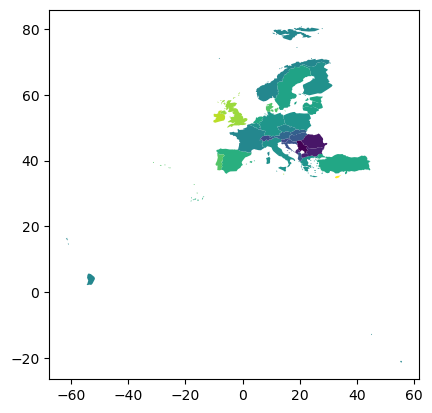

In [9]:
reduced_data_pd.plot("t2m")
print('# Note that the NUTS regions include French foreign territories, hence the extent of the figure.')

## Appendix

### Unadvised: return_as = 'pandas' for time-series

This results in very heavy memory usage but may be useful

In [10]:
reduced_data_pd = ekt.spatial.reduce(era5_xr, nuts_data, return_as="pandas", mask_dim="FID")
reduced_data_pd[:5]

Returning reduced data in pandas format is considered experimental and may change in futureversions of earthkit


id NUTS_ID  LEVL_CODE CNTR_CODE NAME_LATN NUTS_NAME  \
FID valid_time                                                                 
DK  2015-01-01 00:00:00  DK      DK          0        DK   Danmark   Danmark   
    2015-01-01 01:00:00  DK      DK          0        DK   Danmark   Danmark   
    2015-01-01 02:00:00  DK      DK          0        DK   Danmark   Danmark   
    2015-01-01 03:00:00  DK      DK          0        DK   Danmark   Danmark   
    2015-01-01 04:00:00  DK      DK          0        DK   Danmark   Danmark   

                         MOUNT_TYPE  URBN_TYPE  COAST_TYPE FID  \
FID valid_time                                                   
DK  2015-01-01 00:00:00           0          0           0  DK   
    2015-01-01 01:00:00           0          0           0  DK   
    2015-01-01 02:00:00           0          0           0  DK   
    2015-01-01 03:00:00           0          0           0  DK   
    2015-01-01 04:00:00           0          0           0  DK   

                                                                  geometry  \
FID valid_time                                                               
DK  2015-01-01 00:00:00  MULTIPOLYGON (((15.1629 55.0937, 15.094 54.996...   
    2015-01-01 01:00:00  MULTIPOLYGON (((15.1629 55.0937, 15.094 54.996...   
    2015-01-01 02:00:00  MULTIPOLYGON (((15.1629 55.0937, 15.094 54.996...   
    2015-01-01 03:00:00  MULTIPOLYGON (((15.1629 55.0937, 15.094 54.996...   
    2015-01-01 04:00:00  MULTIPOLYGON (((15.1629 55.0937, 15.094 54.996...   

                                t2m  
FID valid_time                       
DK  2015-01-01 00:00:00  278.709224  
    2015-01-01 01:00:00  278.938862  
    2015-01-01 02:00:00  279.068517  
    2015-01-01 03:00:00  279.241260  
    2015-01-01 04:00:00  279.418631

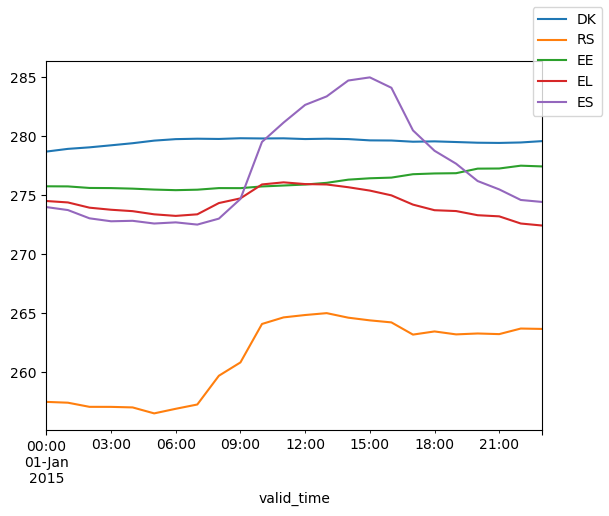

In [11]:
feature_index = "FID"
plot_var = "t2m"
# plot_x_vals = reduced_data.attrs[f"{plot_var}_dims"]["time"]
fig, ax = plt.subplots(1)
for feature in reduced_data_pd.index.get_level_values(feature_index).unique()[:5]:
    temp = reduced_data_pd.xs(feature, level=feature_index)
    temp[plot_var].plot(ax=ax, label=feature)
fig.legend()

## Providing a bespoke function for the reduction

When providing a our own function to the reduce method it must conform the the Xarray requirements defined in their [documentation pages](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.reduce.html#xarray-dataarray-reduce). Specifically:

*"Function which can be called in the form f(x, axis=axis, \*\*kwargs) to return the result of reducing an np.ndarray over an integer valued axis."*

Here we will calculate the ratio of the standard deviation to the mean for demonstration purposes only. We use nanmean and nanstd so that we ignore the nan values.

In [12]:
def std_mean_ratio(x, axis=0, **kwargs):
    return np.nanstd(x, axis=axis, **kwargs) / np.nanmean(x, axis=axis, **kwargs)

In [13]:
reduced_data = ekt.spatial.reduce(
    era5_xr, nuts_data,
    how = std_mean_ratio
)
reduced_data

/home/runner/micromamba/envs/DEVELOP/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/runner/micromamba/envs/DEVELOP/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


<xarray.Dataset> Size: 8kB
Dimensions:     (valid_time: 24, index: 37)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 192B 2015-01-01 ... 2015-01-01T23...
  * index       (index) int64 296B 0 1 2 3 4 5 6 7 8 ... 29 30 31 32 33 34 35 36
Data variables:
    t2m         (index, valid_time) float64 7kB 0.002451 0.002455 ... 0.01744
Attributes: (12/13)
    param:        2t
    paramId:      167
    class:        ea
    stream:       oper
    levtype:      sfc
    type:         an
    ...           ...
    date:         20150101
    time:         0
    domain:       g
    number:       0
    Conventions:  CF-1.8
    institution:  ECMWF